In [23]:
from helper import phys
import numpy as np
import emcee
import random
import pandas as pd
import astropy.io.ascii as asci
import scipy.optimize as op
import astropy.constants as const
from astropy.time import Time
from astropy.table import Table
from collections import OrderedDict as odict
from allsn_info import get_at2019dge

In [24]:
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
fs = 14
matplotlib.rcParams['font.size']=fs

### Prepare the data

In [3]:
result = get_at2019dge(colorplt=False)
lc = result['tb']

In [4]:
lc = lc[lc.instrument!='P60+SEDM']
lcdet = lc.sort_values(by = ['mjd'])

In [5]:
dates = np.unique(lcdet["date"].values)

In [6]:
flags = np.ones(len(dates), dtype = int)
indlc = np.ones(len(lcdet), dtype = int)

In [7]:
for i in range(len(dates)):
    mydate = dates[i]
    ix = lcdet['date'].values == mydate
    lckeck = lcdet[ix]
    allwv = np.unique(lckeck['wave'].values)
    # we need at least three bands to fit a blackbody
    for j in range(15):
        if len(allwv)==j:
            flags[i] = j
            indlc[ix] = j

In [8]:
lcdet1 = lcdet[indlc>=2]
dates1 = dates[flags>=2]

#lcdet2 = lcdet[indlc==2]
#dates2 = dates[flags==2]

In [9]:
dates1.shape

(23,)

In [10]:
np.save('./helper/19dge_dates.npy', dates1)
#np.save('./helper/dates2.npy', dates2)
lcdet1.to_csv("./helper/19dge_lcdet.csv")
#lcdet2.to_csv("./helper/lcdet_2bands.csv")

### Blackbody fit (with MCMC)

run helper.mcmcfit, helper.mcmcfit_lgprior, helper.mcmcfit_Jeffprior on cluster

### Construct SEDs

In [11]:
from helper.mcmcfit import planck_lambda, mylinear_fit

In [12]:
dates = np.load('./helper/19dge_dates.npy', allow_pickle=True)
lcdet = pd.read_csv("./helper/19dge_lcdet.csv")

In [13]:
    Tbbs = np.zeros(len(dates))
    Rbbs = np.zeros(len(dates))
    Lbbs = np.zeros(len(dates))
    lgLbbs = np.zeros(len(dates))
    
    Tbbs_unc = np.zeros(len(dates))
    Rbbs_unc = np.zeros(len(dates))
    Lbbs_unc = np.zeros(len(dates))
    lgLbbs_unc = np.zeros(len(dates))
    
    Tbbs_uncl = np.zeros(len(dates))
    Rbbs_uncl = np.zeros(len(dates))
    Lbbs_uncl = np.zeros(len(dates))
    lgLbbs_uncl = np.zeros(len(dates))
    
    Tbbs_uncr = np.zeros(len(dates))
    Rbbs_uncr = np.zeros(len(dates))
    Lbbs_uncr = np.zeros(len(dates))
    lgLbbs_uncr = np.zeros(len(dates))
    
    nramdom = 30
    T_ramdoms = np.zeros((len(dates), nramdom))
    R_ramdoms = np.zeros((len(dates), nramdom))

In [18]:
for i in range(len(dates)):
    mydate = dates[i]
    s = "_"
    filename = "./helper/19dge_mcmcresult/sampler_log_"+s.join(mydate.split(' '))+".h5"
    reader = emcee.backends.HDFBackend(filename)
    chains = reader.get_chain()
    nsteps = chains.shape[0]
    samples = reader.get_chain(flat=True)
    print (i,  mydate)
    tau = reader.get_autocorr_time(tol=0)
    nburn = int(5*np.max(tau))
    if nburn > nsteps-100:
        nburn = nsteps-100
    print ("    nburn = %d"%nburn)
    samples = samples[nburn:, :]
    
    Ts = 10**samples[:,0]
    Rs = 10**samples[:,1]
    Lbbs_run = const.sigma_sb.cgs.value * Ts **4 * 4 * np.pi * (Rs * const.R_sun.cgs.value)**2
    Lbb_sigmas = np.percentile(Lbbs_run, (0.13, 2.27, 15.87, 50, 84.13, 97.73, 99.87))
    Tbb_sigmas = np.percentile(Ts, (0.13, 2.27, 15.87, 50, 84.13, 97.73, 99.87))
    Rbb_sigmas = np.percentile(Rs, (0.13, 2.27, 15.87, 50, 84.13, 97.73, 99.87))
    
    ix_random = np.array([random.randint(0, len(samples)-1) for x in range(nramdom)])
    
    T_ramdoms[i] = Ts[ix_random]
    R_ramdoms[i] = Rs[ix_random]
    
    pars = np.vstack([Lbb_sigmas, Tbb_sigmas, Rbb_sigmas])
    
    Lbbs[i] = pars[0][3]
    Lbbs_unc[i] = (pars[0][4]-pars[0][2])/2
    Lbbs_uncr[i] = pars[0][4]-pars[0][3]
    Lbbs_uncl[i] = pars[0][3]-pars[0][2]   
        
    lgLbbs[i] = np.log10(pars[0][3])
    lgLbbs_unc[i] = (np.log10(pars[0][4])-np.log10(pars[0][2]))/2
    lgLbbs_uncr[i] = np.log10(pars[0][4])-np.log10(pars[0][3])
    lgLbbs_uncl[i] = np.log10(pars[0][3])-np.log10(pars[0][2])
        
    Tbbs[i] = pars[1][3]
    Tbbs_unc[i] = (pars[1][4]-pars[1][2])/2
    Tbbs_uncr[i] = pars[1][4]-pars[1][3]
    Tbbs_uncl[i] = pars[1][3]-pars[1][2]
                
    Rbbs[i] = pars[2][3]
    Rbbs_unc[i] = (pars[2][4]-pars[2][2])/2
    Rbbs_uncr[i] = pars[2][4]-pars[2][3]
    Rbbs_uncl[i] = pars[2][3]-pars[2][2]     

0 2019 04 07
    nburn = 2316
1 2019 04 08
    nburn = 444
2 2019 04 09
    nburn = 153
3 2019 04 10
    nburn = 144
4 2019 04 11
    nburn = 150
5 2019 04 13
    nburn = 143
6 2019 04 14
    nburn = 156
7 2019 04 15
    nburn = 143
8 2019 04 17
    nburn = 151
9 2019 04 18
    nburn = 149
10 2019 04 19
    nburn = 145
11 2019 04 20
    nburn = 161
12 2019 04 21
    nburn = 157
13 2019 04 22
    nburn = 138
14 2019 04 23
    nburn = 144
15 2019 04 24
    nburn = 152
16 2019 04 25
    nburn = 163
17 2019 04 26
    nburn = 150
18 2019 05 04
    nburn = 165
19 2019 05 07
    nburn = 141
20 2019 05 08
    nburn = 154
21 2019 05 09
    nburn = 218
22 2019 05 13
    nburn = 156


In [19]:
    t0jd = result['t_max']
    
    jds = np.zeros(len(dates))
    nrow = 5
    ncol = 5

In [22]:
Rbbs

array([1450.46400315, 2197.6062166 , 3495.6889582 , 4461.4834487 ,
       4887.4271939 , 7264.18082831, 7383.91938672, 8772.08837267,
       7087.8545019 , 7997.94339879, 6792.73273738, 7420.26978821,
       6626.14338181, 7422.63711054, 7517.20346061, 7051.61892818,
       7295.96904258, 6173.72880219, 5472.03463884, 4076.8460302 ,
       5733.39649696, 4761.79979716, 6992.79882934])

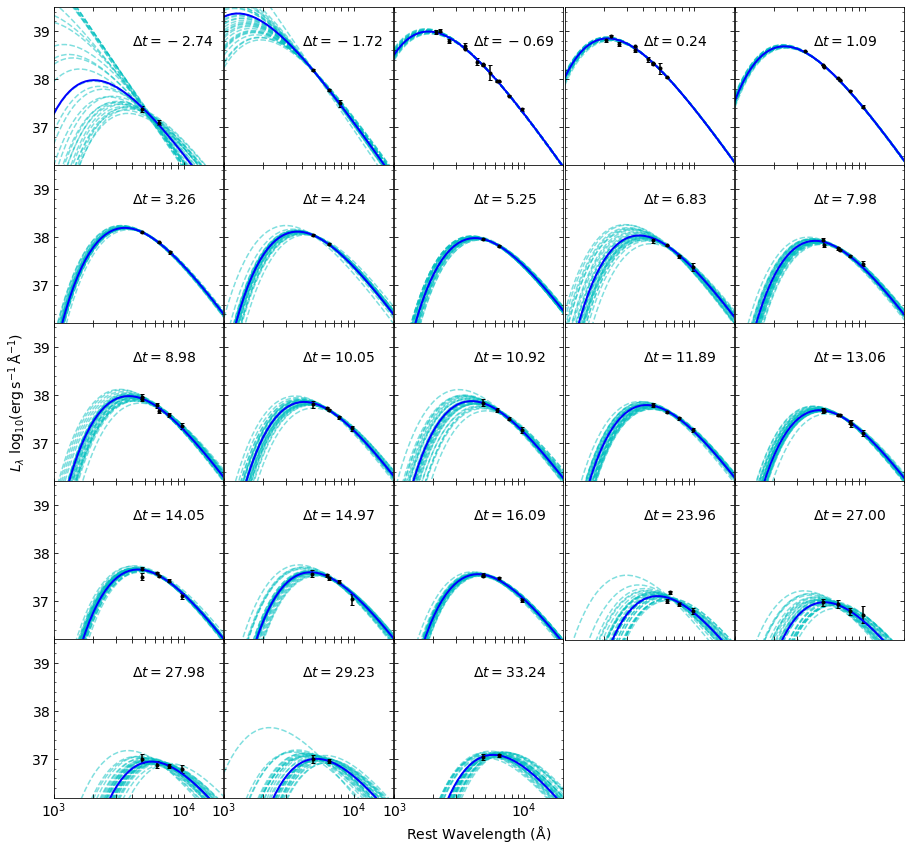

In [25]:
    fig, axes = plt.subplots(nrow, ncol, figsize=(13, 12), sharey=True, sharex=True)
    
    lamb = np.logspace(3, 4.5)
    
    for ind in range(len(dates)):
        mydate = dates[ind]
        i = np.where(dates == mydate)[0][0]
        
        ix = lcdet['date'].values == mydate
        lckeck = lcdet[ix]
        nband = len(np.unique(lckeck['wave'].values))
            
        ii = i // ncol
        jj = i % ncol
        
        t = np.mean(lckeck['mjd'].values)
        jds[i] = t
               
            
        x = lckeck['wave'].values
        y = lckeck['Llambda'].values
        yerr = lckeck['Llambda_unc'].values
                
        lgLlambdas = np.log10(y)
        lgLlambdas_unc = 1 / np.log(10) * yerr / y
                
        flux = planck_lambda(Tbbs[i], Rbbs[i], lamb)
        deltat = t - t0jd
        ax = axes[ii,jj]        
        ax.errorbar(x, lgLlambdas, lgLlambdas_unc, fmt='.k', capsize=2)
        ax.plot(lamb, np.log10(flux), color='b', linewidth = 2, zorder = 2)
        ax.set_xlim(1000, 20000)
        ax.set_ylim(36.2, 39.5)
        ax.semilogx()
        
        for j in range(nramdom):
            fluxnew = planck_lambda(T_ramdoms[i][j], R_ramdoms[i][j], lamb)
            ax.plot(lamb, np.log10(fluxnew), color='c', alpha = 0.5, linestyle = "--", linewidth = 1.5, zorder = 1)
                
        if ii!=nrow-1:
            ax.set_xticks([1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000])
            ax.set_xticklabels(['', '', '', '', '', '', '', '', '', ''])
        else:
            ax.set_xticks([1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000])
            ax.set_xticklabels(['$10^3$', '', '', '', '', '', '', '', '', '$10^4$'])
                
        if deltat>0:
            ax.text(4000, 38.7, '$\Delta t=$%.2f'%deltat, color='k')
        else:
            ax.text(4000, 38.7, '$\Delta t=-$%.2f'%abs(deltat), color='k')
        ax.yaxis.set_minor_locator(AutoMinorLocator())
        ax.tick_params(direction='in', axis='both', which = 'both', top=True, right=True)
        ax.tick_params(which='major', length=4)
        ax.tick_params(which='minor', length=2)
        
    plt.tight_layout(rect = (0.03, 0.02, 1, 1), # left, bottom, right, top
                     h_pad=-0.09, w_pad=-1.25)
    axes[4,2].set_xlabel("Rest Wavelength"+' ('+r'$\rm \AA$'+')')
    axes[2,0].set_ylabel(r'$L_{\lambda}$ log'+r'$_{10}\rm(erg\,s^{-1}\,\AA^{-1})$')
    
    axes[4,4].set_axis_off()
    axes[4,3].set_axis_off()
    plt.savefig("../paper/figures/seds_log.pdf")
    # plt.close()

In [26]:
trf = jds-t0jd

In [27]:
Lbbs.shape

(23,)

In [28]:
tb = Table(data = [trf, Lbbs, Lbbs_unc, Lbbs_uncr, Lbbs_uncl, 
                       lgLbbs, lgLbbs_unc, lgLbbs_uncr, lgLbbs_uncl, 
                       Tbbs, Tbbs_unc, Tbbs_uncr, Tbbs_uncl,
                       Rbbs, Rbbs_unc, Rbbs_uncr, Rbbs_uncl],
            names = ['phase', 'Lbb', 'Lbb_unc', 'Lbb_uncr', 'Lbb_uncl', 
                        'lgLbb', 'lgLbb_unc', 'lgLbb_uncr', 'lgLbb_uncl',
                        'Tbb', 'Tbb_unc', 'Tbb_uncr', 'Tbb_uncl',
                        'Rbb', 'Rbb_unc', 'Rbb_uncr', 'Rbb_uncl'])

In [29]:
tb.write('../data/otherSN/Yao2020/bbdata.csv', overwrite=True)